Implementation of Project 4:
transfer leaves with a desease to healthy leaves

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

import itertools

from my_code.utilities import *
from my_code.models import Discriminator, ResNet

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 4
lr_g = 1e-3
lr_d = 1e-3
beta1 = 0.999

In [4]:
fn_Cycle = nn.L1Loss()           # L1
fn_GAN = nn.BCEWithLogitsLoss()
fn_Ident = nn.L1Loss()           # L1

In [5]:
iterator_healthy = ImageIterator(device=device, batch_size=batch_size)
iterator_disease = ImageIterator(device=device, batch_size=batch_size)
iterator_disease.set_give_healthy(False)

In [6]:
net_x2y = ResNet(3, 3)
net_y2x = ResNet(3, 3)
net_Dx = Discriminator(3)
net_Dy = Discriminator(3)

net_x2y.train()
net_y2x.train()
net_Dx.train()
net_Dy.train()

Discriminator(
  (dsc0): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (dsc1): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (dsc2): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(128, eps=1e-05, mom

In [7]:
optimG = torch.optim.Adam(itertools.chain(net_x2y.parameters(), 
                                          net_y2x.parameters())
                          , lr=lr_g, betas=(beta1, 0.999))
optimD = torch.optim.Adam(itertools.chain(net_Dx.parameters(), 
                                          net_Dy.parameters()),
                          lr=lr_d, betas=(beta1, 0.999))


In [8]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

### Training the network

In [12]:
n_iteration = 10

for i in range(n_iteration):
    print('running iteration:' + i)
    x = iterator_healthy.__next__()
    y = iterator_disease.__next__()

    x = x
    y = y

    output_x = net_x2y(x)
    output_y = net_y2x(y)

    recon_x = net_x2y(output_x)
    recon_y = net_y2x(output_y)

    set_requires_grad([net_Dx, net_Dy], True)
    optimG.zero_grad()

    # Discriminator loss x
    pred_real_x = net_Dx(x)
    pred_fake_x = net_Dx(output_x.detach())

    loss_Dx_real = fn_GAN(pred_real_x, torch.ones_like(pred_real_x))
    loss_Dx_fake = fn_GAN(pred_fake_x, torch.ones_like(pred_fake_x))
    loss_Dx = 0.5 * (loss_Dx_fake + loss_Dx_real)

    # Discriminator loss y
    pred_real_y = net_Dy(y)
    pred_fake_y = net_Dy(output_y.detach())

    loss_Dy_real = fn_GAN(pred_real_y, torch.ones_like(pred_real_y))
    loss_Dy_fake = fn_GAN(pred_fake_y, torch.ones_like(pred_fake_y))
    loss_Dy = 0.5 * (loss_Dy_fake + loss_Dy_real)

    loss_D = loss_Dx + loss_Dy
    loss_D.backward()
    optimD.step()

    # Generator training

    set_requires_grad([net_Dx, net_Dy], False)
    optimG.zero_grad()

    ident_y = net_x2y(y)
    ident_x = net_y2x(x)

    loss_I_x = fn_Ident(ident_x, x)
    loss_I_y = fn_Ident(ident_y, y)

    pred_fake_x = net_Dx(output_x)
    pred_fake_y = net_Dx(output_y)

    loss_G_x2y = fn_GAN(pred_fake_y, torch.ones_like(pred_fake_y))
    loss_G_y2x = fn_GAN(pred_fake_x, torch.ones_like(pred_fake_x))

    loss_C_x = fn_Cycle(x, recon_x)
    loss_C_y = fn_Cycle(y, recon_y)

    loss_G = (loss_G_x2y + loss_G_y2x) + \
                (1 * loss_C_x + 1 * loss_C_y) + \
                (1 * loss_I_x + 1 * loss_I_y) * 1

    loss_G.backward()
    optimG.step()

In [13]:
y = iterator_disease.__next__()

im = net_y2x(y)
im = im.detach().numpy()
im = im.swapaxes(1, 3)

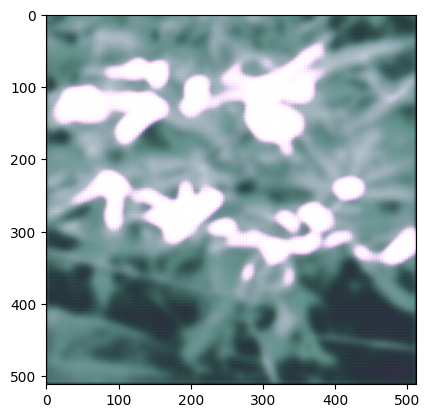

In [14]:
plt.imshow(im[0])

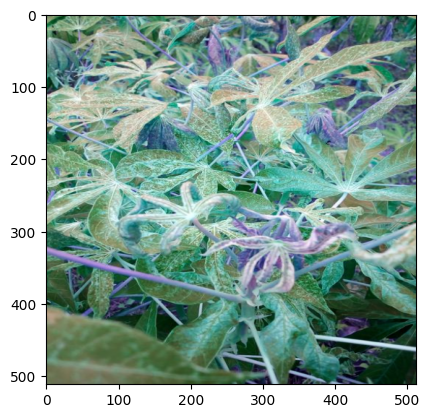

In [15]:
plt.imshow(y.detach().numpy()[0].swapaxes(0, 2))